<h1>The Titanic Dataset</h1>

In [1]:
# data basics
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns

# data preprocessing
from sklearn.preprocessing import StandardScaler, LabelEncoder

# models
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

# metrics
from sklearn.model_selection import cross_val_score

# optimization
from sklearn.model_selection import GridSearchCV

In [2]:
# load data and inspect
train = pd.read_csv('train.csv', index_col='PassengerId')
train.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [3]:
# percent of data na
pd.DataFrame((train.isna().sum()/len(train)), columns=['Fraction Nan']).T

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
Fraction Nan,0.0,0.0,0.0,0.0,0.198653,0.0,0.0,0.0,0.0,0.771044,0.002245


<h2>EDA: <i>Pclass</i></h2>

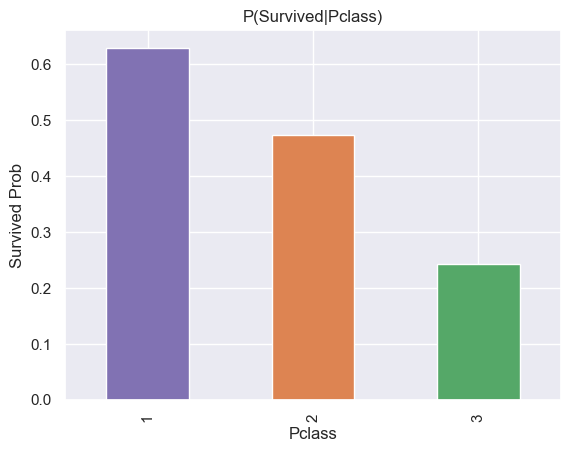

In [4]:
# plot P(Survived|Pclass)

Prob_sur_pcl = train.groupby('Pclass').Survived.mean()
sns.set_theme()
Prob_sur_pcl.plot.bar(color=['C4', 'C1', 'C2'])
plt.title('P(Survived|Pclass)')
plt.ylabel('Survived Prob')
plt.show()

<h4><i>Pclass</i> has a negative correlation with Survived and is a good candidate for model input.</h4><br><br>

<h2>EDA: <i>Sex</i></h2>

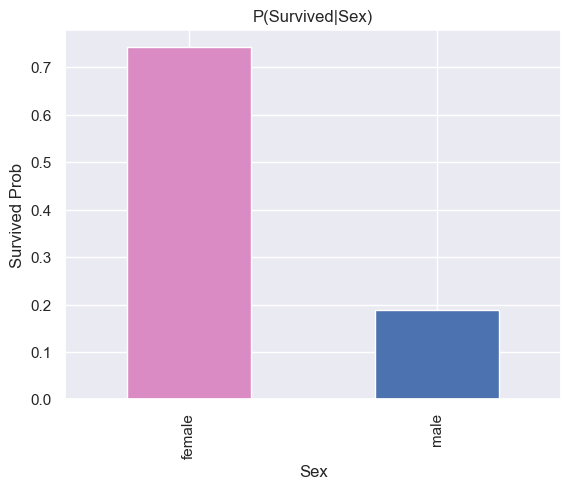

In [5]:
# plot P(Survived|Sex)
Prob_sur_sex = train.groupby('Sex').Survived.mean()
sns.set_theme()
Prob_sur_sex.plot.bar(color=['C6', 'C0'])
plt.title('P(Survived|Sex)')
plt.ylabel('Survived Prob')
plt.show()

<h4>P(Survival|<i>Sex</i>=female) is high and P(Survival|<i>Sex</i>=male) is low making <i>Sex</i> a good candidate for model input.</h4><br><br>

<h2>EDA: <i>Parch</i> & <i>SibSp</i></h2>

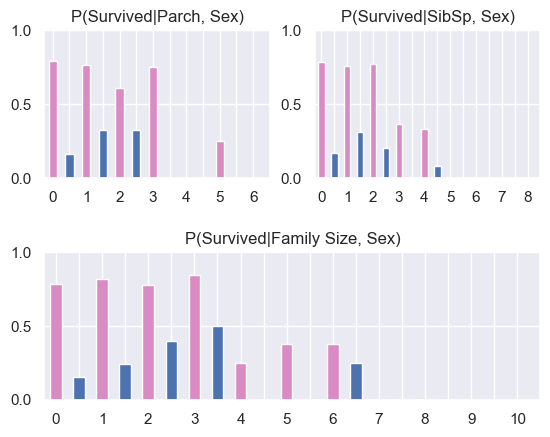

In [22]:
# get plot data
Prob_sur_par = train.groupby(['Parch','Sex']).Survived.mean()
Prob_sur_sib = train.groupby(['SibSp','Sex']).Survived.mean()
train['family_size'] = train['Parch'] + train['SibSp']
Prob_sur_fam = train.groupby(['family_size','Sex']).Survived.mean()

# create grid init fig
grid  = gridspec.GridSpec(2, 2)
fig   = plt.figure()

# create subplots
parch = fig.add_subplot(grid[0,0])
sibsp = fig.add_subplot(grid[0,1])
famsz = fig.add_subplot(grid[1,0:2])

# plot P(Survived|Parch)
Prob_sur_par.plot.bar(ax=parch, color=['C6','C0'])
parch.set_title('P(Survived|Parch, Sex)')
parch.set_xlabel('')
parch.set_yticks(ticks=[0,.5,1])
parch.set_xticks(ticks=list(range(14)), labels=[l for n in range(7) for l in (n, '')], rotation=0)

# plot P(Survived|SibSp)
Prob_sur_sib.plot.bar(ax=sibsp, color=['C6','C0'])
sibsp.set_title('P(Survived|SibSp, Sex)')
sibsp.set_xlabel('')
sibsp.set_yticks(ticks=[0,.5,1])
sibsp.set_xticks(ticks=list(range(18)), labels=[l for n in range(9) for l in (n, '')], rotation=0)

# plot P(Survived|Famsz)
Prob_sur_fam.plot.bar(ax=famsz, color=['C6','C0'])
famsz.set_title('P(Survived|Family Size, Sex)')
famsz.set_xlabel('')
famsz.set_yticks(ticks=[0,.5,1])
famsz.set_xticks(ticks=list(range(22)), labels=[l for n in range(11) for l in (n, '')], rotation=0)

plt.subplots_adjust(hspace=0.5)
plt.show()

<h4>By combining <i>Parch</i> & <i>SibSp</i> to <i>Family Size</i>:<ul>
    <li>number of features is reduced</li><li>P(Survived|Family Size, Sex=Male) is simplified</li><li>the grim fate of a large family is still retained</li></ul></h4>

<h2>EDA: <i>Age</i></h2>

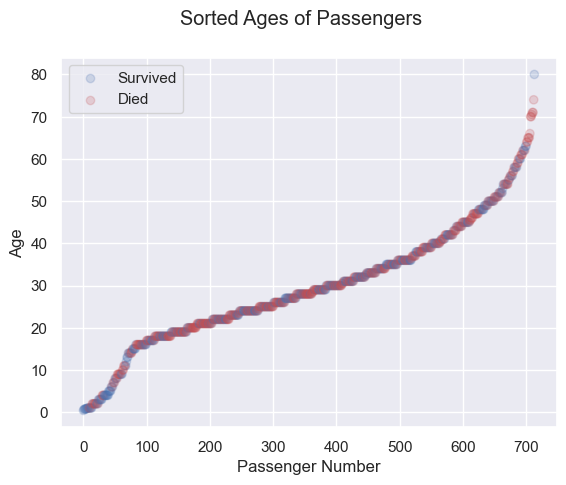

In [23]:
age = train.sort_values('Age').reset_index(drop=True)
color = ['C0' if x==1 else 'C3' for x in age.Survived]

# plot
plt.scatter(age.index, age.Age, c=color, alpha=.2)

# labels
plt.suptitle('Sorted Ages of Passengers')
plt.xlabel('Passenger Number')
plt.ylabel('Age')

# legend
plt.scatter([], [], c='C0', alpha=.2, label='Survived')
plt.scatter([], [], c='C3', alpha=.2, label='Died')
plt.legend()

plt.show()

<h4>P(<i>Survival</i>|<i>Age) is very noisy and will not be used in its raw form for model input.</i></h4><br><br>

<h2>EDA: <i>Fare</i></h2>

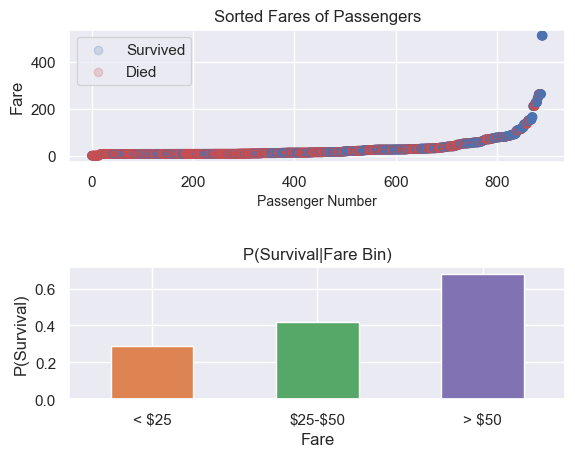

In [24]:
fare = train.sort_values('Fare').reset_index()
fare['bin'] = pd.cut(fare.Fare, [-1, 25, 50, 1000])
fare_binned = fare.groupby('bin').Survived.mean()

color = ['C0' if x==1 else 'C3' for x in fare.Survived]

fig    = plt.figure()
raw    = fig.add_subplot(211)
binned = fig.add_subplot(212)

# plot 1
raw.scatter(fare.index, fare.Fare, c=color)

# labels 1
raw.set_title('Sorted Fares of Passengers')
raw.set_xlabel('Passenger Number', fontsize=10)
raw.set_ylabel('Fare')

# legend 1
raw.scatter([], [], c='C0', alpha=.2, label='Survived')
raw.scatter([], [], c='C3', alpha=.2, label='Died')
raw.legend(loc = 'upper left')



# plot 2
fare_binned.plot.bar(ax=binned, color=['C1', 'C2', 'C4'])

# labels 2
binned.set_title('P(Survival|Fare Bin)')
binned.set_ylabel('P(Survival)')
binned.set_xlabel('Fare')
binned.set_xticks(ticks=[0,1,2], labels=['< $25','\$25-$50','> $50'], rotation=0)


plt.subplots_adjust(hspace=.8)
plt.show()



<h4> Binning <i>Fares</i> simplifies P(<i>Survived</i>|<i>Fares</i>) and leads to increased model performance.

<h2>EDA: <i>Cabin</i></h2>

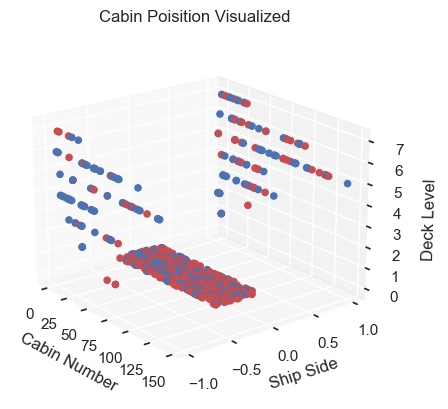

In [9]:
# extract Deck and Cabin_no from Cabin
train[['Deck','Cabin_no']] = train['Cabin'].str.extract(r'([A-G])(\d+)')

# convert Deck to Deck_no and assign nan to Deck_no=0
deck_to_deck_no  = {np.nan:0, 'A':7, 'B':6, 'C':5, 'D':4, 'E':3, 'F':2, 'G':1}
train['Deck_no'] = train['Deck'].map(deck_to_deck_no)

# convert Cabin_no to ship side and assign nan to a spread center position
train['side'] = [np.random.uniform(-.25, .26, 1) if pd.isna(Cabin_no) else 1 \
                 if int(Cabin_no)%2 == 0 else -1 for Cabin_no in train.Cabin_no]

# color by survived
survival_color = {0:'C3', 1:'C0'}
train['color'] = train['Survived'].map(survival_color)


num_points = 100
fill = iter(np.linspace(0, 150, len(train['Deck_no'])))

# assign cols to axes
x = train['Cabin_no'].apply(lambda x: next(fill) if pd.isna(x) else x)
y = train['side']
z = train['Deck_no']
c = train['color']

# init plot
fig = plt.figure()
ax  = fig.add_subplot(111, projection='3d')
ax.set_facecolor('white')

# plot
ax.scatter(x, y, z, c=c, alpha=1)
ax.view_init(azim=-38, elev=20)

ax.set_title('Cabin Poisition Visualized')
ax.set_xlabel('Cabin Number')
ax.set_ylabel('Ship Side')
ax.set_zlabel('Deck Level')
plt.show()

<h4>P(<i>Survived</i>|<i>Cabin</i>) appears to be very noisy.  It will not be used for model input.<br>

<h2>EDA: <i>Embarked</i></h2>

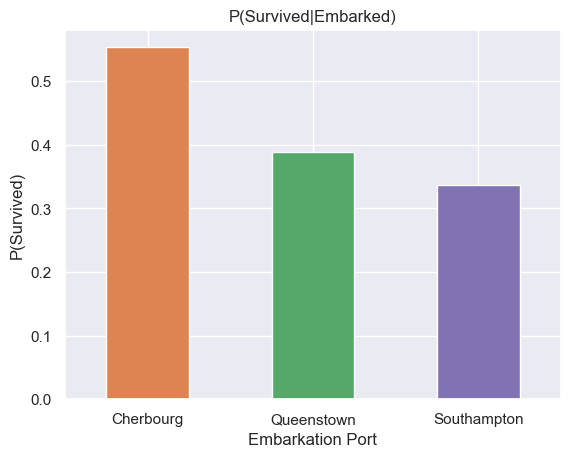

In [10]:
# data
embarked = train.groupby('Embarked').Survived.mean()

# plot
embarked.plot.bar(color=['C1','C2','C4'])

# label
plt.title('P(Survived|Embarked)')
plt.ylabel('P(Survived)')
plt.xlabel('Embarkation Port')
plt.xticks([0,1,2], ['Cherbourg','Queenstown','Southampton'], rotation=0)


plt.show()

<h4>Though the graph shows a correlation, this data actually leads to decreased model performace. <br>For that reason <i>Embarked</i> will not be used for model input.</h4>

<h2>Feature Engineering: <i>Fate</i> </h2>

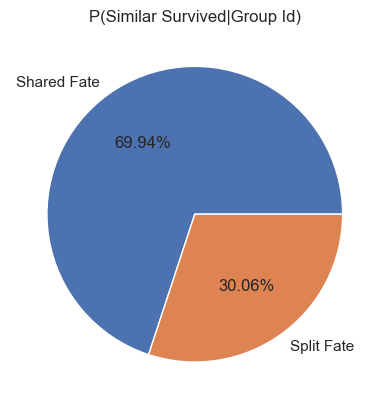

In [11]:
# compile data
train['ticket_count'] = train.Ticket.apply(lambda x: len(train[train.Ticket==x]))
train['last_name']    = train.Name.str.extract(r'([A-Za-z]+)\,')
train['family_code']  = train['last_name'] + train['family_size'].astype(str)
train['family_count'] = train.family_code.apply(lambda x: len(train[train.family_code==x]))
ticket_group          = train['ticket_count'] > 1
train['group_id']     = 'none'
train.loc[ticket_group, 'group_id'] = train.loc[ticket_group, 'Ticket']
no_group              = train['group_id'] == 'none'
has_family            = train['family_count'] > 1
train.loc[no_group&has_family, 'group_id'] = train.loc[no_group&has_family, 'family_code']

# group on group_id
shared_fate = train.groupby('group_id').Survived.mean().value_counts(normalize=True)

# calc shared and split fate
fate_shared = (shared_fate.index > .7) | (shared_fate.index < .3)
party_same  = shared_fate[fate_shared].sum()
party_split = shared_fate[~fate_shared].sum()

# plot
plt.pie([party_same, party_split], labels=['Shared Fate', 'Split Fate'], autopct='%.2f%%')
plt.title('P(Similar Survived|Group Id)')

plt.show()

<h4>Due to strong correlation of <i>Survived</i> among <i>group_id</i>, <i>shared_fate</i> will be included in the model.</h4>

<h2>Data Cleaning and Preprocessing </h2>
<br>
Fit all scalers and encoders

In [12]:
# load data
train = pd.read_csv('train.csv', index_col='PassengerId')

##################
# famsize_scaler #
##################

# data for scaler fit
train['Last_Name']   = train.Name.str.extract(r'([A-Za-z]+)\,')
train['Family_Size'] = train.Parch + train.SibSp

# fit scaler
famsize_scaler = StandardScaler()
famsize_scaler.fit(train['Family_Size'].values.reshape((-1,1)))

###############
# fare_binner #
###############

# data for encoder
fare_bins = [-1, 25,50,1000]
train['Fare'].fillna(train['Fare'].median(), inplace=True)

# fit ordinal encoder
fare_binner = LabelEncoder()
train['Fare_Bins'] = pd.cut(train.Fare, bins=fare_bins)
fare_binner.fit(train['Fare_Bins'])

###################
# fare_bin_scaler #
###################

train['Fare_Bins'] = fare_binner.transform(train['Fare_Bins'])
fare_bin_scaler = StandardScaler()
fare_bin_scaler.fit(train['Fare_Bins'].values.reshape((-1,1)))

StandardScaler()

<h4>All scalers and encoders are now fit</h4>
<h3>Functions to clean and preprocess data</h3>

In [13]:
def get_ticket_fate(row):
    '''
    checks train data for shared ticket survival or death
    then returns to ['Fate'] column
    '''
    same_ticket  = train.Ticket == row.Ticket
    not_this_row = train.index != row.name
    df = train[same_ticket & not_this_row]
    if len(df) == 0:
        return 0
    elif df.Survived.max() == 1:
        return 1
    elif df.Survived.min() == 0:
        return -1

def add_family_fate(row):
    '''
    if no shared ticket fate was found:
    checks train data for shared family survival or death
    then returns to ['Fate'] column
    '''
    same_family  = train.Family_Code == row.Family_Code
    not_this_row = train.index != row.name
    df = train[same_family & not_this_row]
    if row.Fate != 0:
        return row.Fate
    else:
        if len(df) == 0:
            return row.Fate
        elif df.Survived.max() == 1:
            return 1
        elif df.Survived.min() == 0:
            return -1
        
def clean_preprocess(dataframe, train=True):
    '''
    the full clean and preprocessing sequence
    not including training scalers and encoders 
    '''
    # init dataframe with index
    model_data = pd.DataFrame(index=dataframe.index)
    
    # pclass as an ordinal category
    model_data['Pclass'] = dataframe.Pclass.replace([1,2,3], [1, 0, -1])
    
    # sex as an ordinal category
    model_data['Sex']    = dataframe.Sex.replace(['male', 'female'], [-1, 1])

    # calc Family_Size and Scale
    dataframe['Family_Size']  = dataframe.Parch + dataframe.SibSp
    model_data['Family_Size'] = famsize_scaler.transform(dataframe['Family_Size']\
                                                   .values.reshape((-1,1)))
    
    # calc Family_Code for grouping
    dataframe['Last_Name']   = dataframe.Name.str.extract(r'([A-Za-z]+)\,')
    dataframe['Family_Code'] = dataframe['Last_Name'] + dataframe['Family_Size'].astype(str)

    # calc Fate feature
    dataframe['Fate']    = dataframe.apply(get_ticket_fate, axis=1)
    dataframe['Fate']    = dataframe.apply(add_family_fate, axis=1)
    model_data['Fate']   = dataframe['Fate']

    # bin and encode Fare
    dataframe['Fare'].fillna(dataframe['Fare'].median(), inplace=True)
    dataframe['Fare_Bins'] = pd.cut(dataframe.Fare, bins=fare_bins)
    dataframe['Fare_Bins'] = fare_binner.transform(dataframe['Fare_Bins'])
    model_data['Fare_Bins'] = fare_bin_scaler.transform(dataframe['Fare_Bins'].values.reshape((-1,1)))

    if train:
        return model_data, dataframe['Survived']
    else:
        return model_data

In [14]:
X_train, y_train = clean_preprocess(train)
X_train.head()

,Pclass,Sex,Family_Size,Fate,Fare_Bins
PassengerId,,,,,
1,-1,-1,0.059160,-1,-0.712110
2,1,1,0.059160,0,1.856675
3,-1,1,-0.560975,0,-0.712110
4,1,1,0.059160,-1,1.856675
5,-1,-1,-0.560975,1,-0.712110


<h4>All Data has been processced, scaled and encoded.  It's time to select a model.</h4>
KNN, XGBoost, RandomForrest and LogReg will be tested for performance with 5 fold cross validation.

In [15]:
# KNN
knn = KNeighborsClassifier()
knn_score = cross_val_score(knn, X_train, y_train, cv=5)

# XGB
xgbc = XGBClassifier()
xgbc_score = cross_val_score(xgbc, X_train, y_train, cv=5)

# RF
rfc = RandomForestClassifier()
rfc_score = cross_val_score(rfc, X_train, y_train, cv=5)

# LR
lr = LogisticRegression()
lr_score = cross_val_score(lr, X_train, y_train, cv=5)





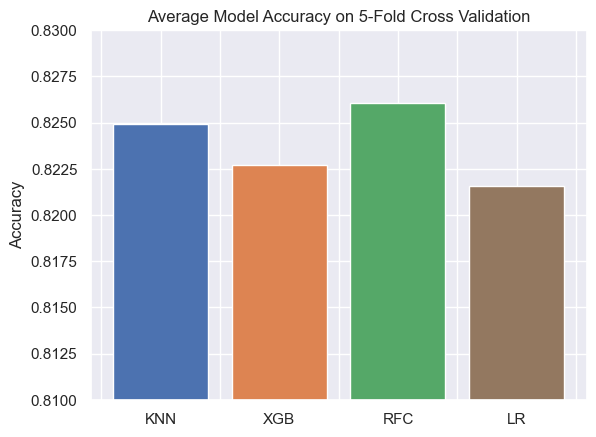

In [27]:
# plot results
plt.bar([0,1,2,3], [knn_score.mean(), xgbc_score.mean(), rfc_score.mean(), lr_score.mean()],
       color=['C0','C1','C2','C5'])
plt.xticks(ticks=np.arange(-.5,4,.5), labels=['','KNN','','XGB','','RFC','','LR',''])
plt.title('Average Model Accuracy on 5-Fold Cross Validation')
plt.ylabel('Accuracy')
plt.ylim(.81,.83)
plt.show()

<h3>Model Performace on Test Set</h3>
<ol>
 <li>0.794 (KNN)</li>
 <li>0.784 (XGBC)</li>
 <li>0.784 (RFC)</li>
 <li>0.775 (LR)</li>
</ol>
<br>
From the data above it seems that <code>KNeighborsClassifier</code> is the most robust to over fitting.  For that reason it will be chosen for hyperparamter optimization.

In [17]:
# GridSearchCV

param_grid = {
    'leaf_size':[5,6,7,8,9,10,15,20],
    'n_neighbors':[5,6,7,8,9,10,15,20]
}

grid_search = GridSearchCV(
    knn, 
    param_grid, 
    scoring='accuracy', 
    cv=5, 
    n_jobs=-1)

grid_search.fit(X_train, y_train)

print(f'''
Best Score:  {grid_search.best_score_}
Best Params: {grid_search.best_params_}
''')


Best Score:  0.8293892411022534
Best Params: {'leaf_size': 15, 'n_neighbors': 8}



<h4>Though GridSearchCV did improve the train cv score, after submitting for X_test there was no improvement.</h4>

Addtional submissions and tweaking revealed optimal parameters to be leaf_size=5, n_neighbors=20 <br>
The larger number of n_neighbors makes the model more robust to overfitting and leads to a score increase of around .01, leaf_size is an internal data structure parameter however dropping it down to 5 did also improve the test score by .005.
<h6> This resulted in a final model accuracy of .808 on the test set.</h6>

<h2>More Optimization</h2>
<br>Searching for outlier groups

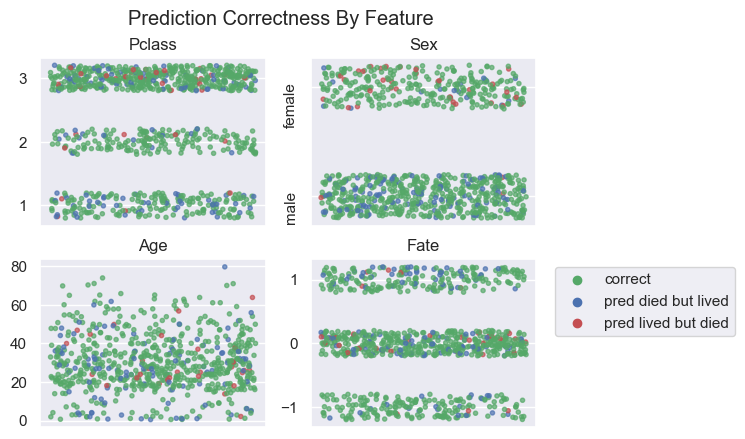

In [18]:
def jitter(iterable, span=.2, add=False):
    'function to "spread" data for visualization'
    if add:
        return [np.random.uniform(-span, span)+x for x in iterable]
    else:
        return [np.random.uniform(-span, span) for _ in iterable]

# get predictions
knn = KNeighborsClassifier(leaf_size=5, n_neighbors=20)
knn.fit(X_train, y_train)
y_pred = knn.predict(X_train)

# append to train
train['y_pred'] = y_pred

# color for easy visualization
train.loc[(train.Survived == train.y_pred), 'color'] = 'C2'
train.loc[(train.Survived == 1) & (train.y_pred == 0), 'color'] = 'C0'
train.loc[(train.Survived == 0) & (train.y_pred == 1), 'color'] = 'C3'

# plot
fig = plt.figure()
alpha=.7


# pclass
pclass = fig.add_subplot(221)
x = jitter(train.Pclass)
y = jitter(train.Pclass, add=True)
pclass.scatter(x, y, c=train.color, alpha=alpha, marker='.')
pclass.set_title('Pclass')
pclass.set_xticks(ticks=[], labels=[])
pclass.set_yticks(ticks=[1,2,3])

# sex
sex = fig.add_subplot(222)
x = jitter(train.Sex)
y = jitter(train.Sex.replace(['male', 'female'], [0,1]), add=True)
sex.scatter(x, y, c=train.color, alpha=alpha, marker='.')
sex.set_title('Sex')
sex.set_xticks(ticks=[], labels=[])
sex.set_yticks(ticks=[0,1], labels=['male', 'female'],rotation=90)

# age
age = fig.add_subplot(223)
x = jitter(train.Age)
y = jitter(train.Age, add=True)
age.scatter(x, y, c=train.color, alpha=alpha, marker='.')
age.set_title('Age')
age.set_xticks(ticks=[], labels=[])

# fate
fate = fig.add_subplot(224)
x = jitter(train.Fate)
y = jitter(train.Fate, add=True)
fate.scatter(x, y, c=train.color, alpha=alpha, marker='.')
fate.set_title('Fate')
fate.set_xticks(ticks=[], labels=[])
plt.suptitle('Prediction Correctness By Feature')

plt.scatter([],[], color='C2', label='correct')
plt.scatter([],[], color='C0', label='pred died but lived')
plt.scatter([],[], color='C3', label='pred lived but died')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', )

plt.show()

Looking at the above data, a pattern can be seen.
<ul>
    <li> model overpredicts male death </li>
    <li> model overpredicts child death </li>
    <li> model overpredicts death for good fate</li>
</ul>

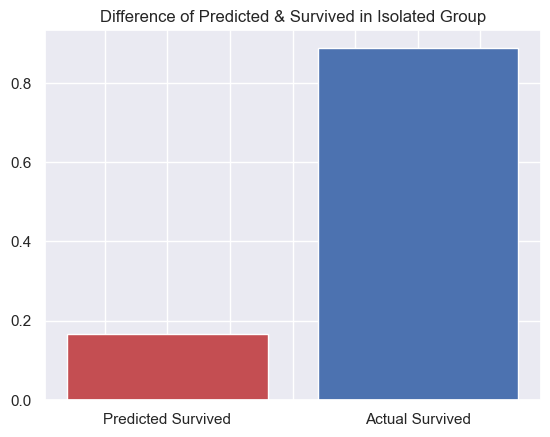

In [28]:
# investigate above finding further

# isolate to overprediction areas
young       = train.Age < 12.5
male        = train.Sex == 'male'
good_fate   = train.Fate >= 1

# find predtions and survived
mean_pred = train[young&male&good_fate].y_pred.mean()
mean_surv = train[young&male&good_fate].Survived.mean()

plt.bar([0,1], [mean_pred,mean_surv], color=['C3','C0'])
plt.xticks(ticks=np.arange(-.25,1.5,.25), labels=['','Predicted Survived', '','','','Actual Survived',''])

plt.title('Difference of Predicted & Survived in Isolated Group')
plt.show()

This small group appears to be "defying the norm".  This can be remedied by adding a custom function to find this "unique group" and set the weights to a survived prediction.<br><br>
This also makes sense from a logical position that if a young boy was part of a group with survivors they would try to save him.

In [30]:
def additional_weights(X, dataframe):
    '''
    searches dataframe for unique isolated group
    if found: adjusts weight in model_data
    '''
    pred_live   = [1,   1,     0,    -1,  -.5]
    young       = dataframe.Age < 12.5
    male        = dataframe.Sex == 'male'
    good_fate   = dataframe.Fate >= 1
    X[young&male&good_fate] = pred_live
    
    
# init model
knn = KNeighborsClassifier(leaf_size=5, n_neighbors=20)

# data
X_train, y_train = clean_preprocess(train)

# fit on unweighted data
knn.fit(X_train, y_train)

# test data
test   = pd.read_csv('test.csv',  index_col='PassengerId')
X_test = clean_preprocess(test, train=False)

# add additional weights
X_test_weighted = additional_weights(X_test, test)

# final prediction
knn_pred = knn.predict(X_test)

In [31]:
# submission
# test['Survived'] = knn_pred
# submission = test['Survived']
# submission.to_csv('submission.csv')

<h4>Using the function additional_weights raised the test score once again to 0.815</h4>
<h2>Find Position on Kaggle Leaderboard</h2>

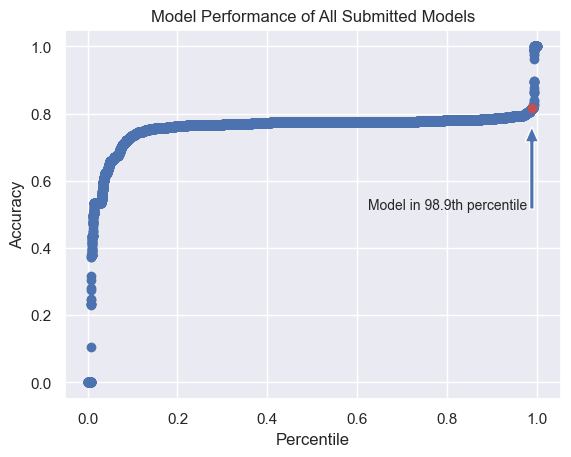

In [29]:
# get public score
public_leaderboard = pd.read_csv('titanic-publicleaderboard.csv')

# order low to high
public_leaderboard = public_leaderboard.iloc[::-1].reset_index(drop=True)
public_leaderboard['percentile'] = np.linspace(0, 1, len(public_leaderboard.index))

# subset
other_models = public_leaderboard[public_leaderboard.TeamName != 'Cody Falkosky']
my_model = public_leaderboard[public_leaderboard.TeamName == 'Cody Falkosky']

# plot
plt.scatter(other_models.percentile, other_models.Score, color='C0')
plt.scatter(my_model.percentile, my_model.Score, color='C3')

model_percentile = f'{my_model.percentile.item()*100:.1f}'
# label
plt.title(f'Model Performance of All Submitted Models')
plt.xlabel('Percentile')
plt.ylabel('Accuracy')

plt.arrow(my_model.percentile.item(), my_model.Score.item()-.3, 0, .2,
         width=.01)

plt.text(my_model.percentile.item()-.01, my_model.Score.item()-.3,
         f'Model in {model_percentile}th percentile', fontsize=10, ha='right')

plt.show()